In [2]:
!pip install haversine

In [157]:
import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
#from scipy.spatial import ConvexHull
#from shapely.geometry import Polygon, Point
from numpy import random
import time
import pandas as pd
from itertools import zip_longest   # zip 함수 길이 다를 경우
from haversine import haversine

In [ ]:
행정동 = '구의제1동'
행정동리스트 = ['구의1동', '화양동','자양1동','자양2동','광장동','중곡4동','구의2동','구의3동', '능동']

In [158]:
입지후보지 = pd.read_csv('입지선정후보군_좌표추가.csv', encoding='EUC-KR')
입지후보지 = 입지후보지[입지후보지['행정동'] == 행정동]
print(입지후보지.shape)
입지후보지.head(2)

(13, 6)


,분류,시설명,x좌표,y좌표,법정동,행정동
478,간이운동장,구의어린이공원,127.094743,37.536502,구의동,구의제1동
739,간이운동장,아차산배수지체육공원,127.096501,37.548963,구의동,구의제1동


In [159]:
버스 = pd.read_csv('서울시_버스정류장_행정동추가.csv')
버스 = 버스[버스['행정동'].isin(행정동리스트)]
print(버스.shape)
버스.head(2)

(106, 7)


,정류소명,X좌표,Y좌표,정류버스수,행정동,행정동_경도,행정동_위도
273,광진구청,127.083386,37.538976,18,구의1동,127.084789,37.543188
304,어린이대공원역.화양천주교회,127.073693,37.546602,17,화양동,127.071368,37.546476


In [160]:
지하철 = pd.read_csv('서울시_지하철역_행정동추가.csv', encoding='EUC-KR', index_col=0)
지하철 = 지하철[지하철['행정동'].isin(행정동리스트)]
print(지하철.shape)
지하철.head(2)

(5, 14)


,전철역코드,전철역명,전철명명(영문),호선,외부코드,검색키워드,주소,위도,경도,환승역,H/B,행정동,행정동_경도,행정동_위도
47,0214,강변역,Gangbyeon,2호선,214,강변역 2호선,서울 광진구 강변역로 53,37.535169,127.094665,0,H,구의3동,127.091961,37.537982
121,0213,구의역,Guui,2호선,213,구의역 2호선,서울 광진구 아차산로 384-1,37.537154,127.086179,0,H,자양2동,127.084415,37.528844


In [161]:
주차장 = pd.read_csv('서울시_주차장_행정동추가.csv', encoding='EUC-KR', index_col=0).drop('Unnamed: 0.1', axis=1)
주차장 = 주차장[주차장['행정동'].isin(행정동리스트)]
print(주차장.shape)
주차장.head(2)

(15, 9)


,주차장id,주차장이름,주소,경도,위도,H/B,행정동,행정동_경도,행정동_위도
289,20589068,화양동 공영주차장,서울 광진구 화양동 63-2,127.071176,37.545298,H,화양동,127.071368,37.546476
291,20589328,능동공영주차장,서울 광진구 능동 205,127.080261,37.554043,H,능동,127.080537,37.553779


In [162]:
주택 = pd.read_csv('서울시주택_행정동추가.csv', encoding='EUC-KR', index_col=0).drop('Unnamed: 0.1', axis=1)
주택 = 주택[주택['행정동'].isin(행정동리스트)]
print(주택.shape)
주택.head(2)

(3, 14)


,구명,단지명,주택유형,세대수,입주개시일,주소,우편번호,전화번호,경도,위도,H/B,행정동,행정동_경도,행정동_위도
117,광진구,한라녹턴,재건축,72,2009-09-11,영화사로16길 43 (구의동 구의동 아차산 한라아파트),4957,NaN,37.553835,127.097346,H,구의2동,127.089936,37.547246
118,광진구,래미안프리미어팰리스,재건축재개발,264,2017-11-01,아차산로 345(자양동 래미안프리미어팰리스아파트),5026,NaN,37.537505,127.081583,H,자양1동,127.082440,37.534507


In [163]:
버스_points = np.array([list(i) for i in zip(버스['X좌표'], 버스['Y좌표'])])
print(버스_points.shape)
버스_points[:2]

(106, 2)


array([[127.08338592,  37.53897619],
       [127.07369304,  37.54660224]])

In [164]:
지하철_points = np.array([list(i) for i in zip(지하철['경도'], 지하철['위도'])])
print(지하철_points.shape)
지하철_points[:2]

(5, 2)


array([[127.09466457,  37.53516928],
       [127.08617923,  37.53715356]])

In [165]:
주차장_points = np.array([list(i) for i in zip(주차장['경도'], 주차장['위도'])])
print(주차장_points.shape)
주차장_points[:2]

(15, 2)


array([[127.07117639,  37.54529787],
       [127.08026103,  37.55404254]])

In [166]:
주택_points = np.array([list(i) for i in zip(주택['위도'], 주택['경도'])])   # 위도 경도 바뀜
print(주택_points.shape)
주택_points[:2]

(3, 2)


array([[127.09734622,  37.55383544],
       [127.08158296,  37.53750524]])

In [167]:
X = list(버스['X좌표']) + list(지하철['경도']) + list(주차장['경도']) + list(주택['위도'])     # 주택 위도 경도 이름 바뀜
X[:2]

[127.0833859175, 127.0736930425]

In [168]:
Y = list(버스['Y좌표']) + list(지하철['위도']) + list(주차장['위도']) + list(주택['경도'])
Y[:2]

[37.5389761877, 37.5466022392]

In [169]:
points = np.array([list(i) for i in zip(X, Y)])
print(points.shape)
points[:2]

(129, 2)


array([[127.08338592,  37.53897619],
       [127.07369304,  37.54660224]])

In [44]:
# # 보유하고 있는 좌표(points)의 모양에 맞는 도형 생성
# # 해당 도형 안에 포함되는 random한 좌표 생성 (임의의 노인놀이터 위치 좌표)
# def generate_candidate_sites(points, M=100):
#     '''
#     Generate M candidate sites with the convex hull of a point set
#     Input:
#         points: 버스정류장, 지하철역 위치 좌표 등 (기타 인근에 있으면 좋은 시설 좌표)
#         M: 생성할 random 좌표 수 (임의의 노인놀이터 수)
#     Return:
#         sites: a Numpy array with shape of (M,2)
#     '''
#     hull = ConvexHull(points)                                   # points 좌표들의 외곽선 생성
#     polygon_points = points[hull.vertices]                      # 외곽선을 구성하는 직선 간 점(좌표) 반환
#     poly = Polygon(polygon_points)                              # 외곽선 모양의 도형 생성
#     min_x, min_y, max_x, max_y = poly.bounds                    # 도형의 x축과 y축 좌표 최소,최대
#     sites = []
#     while len(sites) < M:
#         random_point = Point([random.uniform(min_x, max_x),     # x축 범위 내 random한 값
#                               random.uniform(min_y, max_y)])    # y축 범위 내 random한 값
#         if (random_point.within(poly)):                         # random한 좌표가 도형 안에 있다면 sites에 추가
#             sites.append(random_point)
#     return np.array([(p.x,p.y) for p in sites])

In [69]:
# # haversine -> meter 단위로 수정
# def mclp(버스_points, 지하철_points, 주차장_points, 주택_points, points, K, radius):
    
#     """
#     Solve maximum covering location problem
#     Input:
#         points: 버스정류장, 지하철역 위치 좌표 등 (기타 인근에 있으면 좋은 시설 좌표)
#         K: 배치할 노인놀이터의 수
#         radius: 반경 (노인들이 이동하기 적합한 거리)
#         M: generate_candidate_sites 함수에서 생성할 random 좌표 수 (임의의 노인놀이터 수)
#         the ConvexHull wrapped by the polygon
#     Return:
#         opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
#         f: the optimal value of the objective function
#     """
    
#     print('  Number of points %g' % points.shape[0])
#     print('  K %g' % K)
#     print('  Radius %g' % radius)

#     start = time.time()
#     sites = np.array([list(i) for i in zip(입지후보지['x좌표'], 입지후보지['y좌표'])])
#     J = sites.shape[0]                                         # 후보지 수
    
#     # 수요지점 수
#     A = 버스_points.shape[0]
#     B = 지하철_points.shape[0]
#     C = 주차장_points.shape[0]
#     D = 주택_points.shape[0]
    
#     # 후보지와 수요지점 간 거리 계산
#     D1 = []
#     for i in 버스_points:
#         site = []
#         for j in sites:
#             site.append(haversine(i, j)*1000)
#         D1.append(site)
#     D1 = np.array(D1)
    
#     D2 = []
#     for i in 지하철_points:
#         site = []
#         for j in sites:
#             site.append(haversine(i, j)*1000)
#         D2.append(site)
#     D2 = np.array(D2)    
    
#     D3 = []
#     for i in 주차장_points:
#         site = []
#         for j in sites:
#             site.append(haversine(i, j)*1000)
#         D3.append(site)
#     D3 = np.array(D3)
    
#     D4 = []
#     for i in 주택_points:
#         site = []
#         for j in sites:
#             site.append(haversine(i, j)*1000)
#         D4.append(site)
#     D4 = np.array(D4)
    
#     for i in [D1, D2, D3, D4]:
#         mask1 = i<=radius
#         i[mask1]=1                                                 # 반경 내 속하면 1, 아니면 0
#         i[~mask1]=0

#     m = Model()
#     x1, x2, x3, x4 = {}, {}, {}, {}
#     y = {}
    
#     # 수요지점 변수 추가
#     for i in range(A):                                       
#         x1[i] = m.addVar(vtype=GRB.BINARY, name="x1%d" % i)
#     for i in range(B):                                       
#         x2[i] = m.addVar(vtype=GRB.BINARY, name="x2%d" % i)
#     for i in range(C):                                       
#         x3[i] = m.addVar(vtype=GRB.BINARY, name="x3%d" % i)
#     for i in range(D):                                       
#         x4[i] = m.addVar(vtype=GRB.BINARY, name="x4%d" % i)
    
#     for j in range(J):
#         y[j] = m.addVar(vtype=GRB.BINARY, name="y%d" % j)     # 후보지 변수 추가

#     m.update()
#     m.addConstr(quicksum(y[j] for j in range(J)) == K)        # 후보지 제약 조건

#     # 수요지점 제약 조건
#     for i in range(A): 
#         m.addConstr(quicksum(y[j] for j in np.where(D1[i]==1)[0]) >= x1[i])
#     for i in range(B): 
#         m.addConstr(quicksum(y[j] for j in np.where(D2[i]==1)[0]) >= x2[i])
#     for i in range(C): 
#         m.addConstr(quicksum(y[j] for j in np.where(D3[i]==1)[0]) >= x3[i])
#     for i in range(D): 
#         m.addConstr(quicksum(y[j] for j in np.where(D4[i]==1)[0]) >= x4[i])

# # #     # 목적함수 수정
    
# # #     for a, b, c, d in zip_longest(range(A),range(B),range(C),range(D), fillvalue=0):
# #         if a == 0:
# #             w1 = 0
# #         else:
# #             w1 = 1
# #         if b == 0:
# #             w2 = 0
# #         else:
# #             w2 = 1
# #         if c == 0:
# #             w3 = 0
# #         else:
# #             w3 = 1
# #         if d == 0:
# #             w4 = 0
# #         else:
# #             w4 = 1
# #         m.setObjective(quicksum(w1*x1[a] + w2*x2[b] + w3*x3[c] + w4*x4[d]), GRB.MAXIMIZE)
        
    
#     # 목적함수 수정
#     w1=[]; w2=[]; w3=[]; w4=[]
    
#     for a,b,c,d in zip_longest(range(A),range(B),range(C),range(D), fillvalue=0):
#         if a == 0:
#             w1[a] = 0
#         else:
#             w1[a] = 1
#         if b == 0:
#             w2[b] = 0
#         else:
#             w2[b] = 1
#         if c == 0:
#             w3[c] = 0
#         else:
#             w3[c] = 1
#         if d == 0:
#             w4[d] = 0
#         else:
#             w4[d] = 1
        
#         w1.append(w1)
#         w2.append(w2)
#         w3.append(w3)
#         w4.append(w4)
    
#     m.setObjective(quicksum(w1[a]*x1[a] + w2[b]*x2[b] + w3[c]*x3[c] + w4[d]*x4[d] \
#                             for a,b,c,d in zip_longest(range(A),range(B),range(C),range(D), fillvalue=0)),\
#                    GRB.MAXIMIZE)   # 제약조건 포함, 모든 수요지점 더하기
    
#     m.setParam('OutputFlag', 0)
#     m.optimize()
#     end = time.time()
#     print('----- Output -----')
#     print('  Running time : %s seconds' % float(end-start))
#     print('  Optimal coverage points: %g' % m.objVal)
    
#     solution = []
#     if m.status == GRB.Status.OPTIMAL:
#         for v in m.getVars():
#             # print v.varName,v.x
#             if v.x==1 and v.varName[0]=="y":
#                 solution.append(int(v.varName[1:]))
#     opt_sites = sites[solution]
#     return opt_sites,m.objVal

In [71]:
# def mclp(버스_points, 지하철_points, 주차장_points, 주택_points, points, K, radius):
#     """
#     Solve maximum covering location problem
#     Input:
#         points: 버스정류장, 지하철역 위치 좌표 등 (기타 인근에 있으면 좋은 시설 좌표)
#         K: 배치할 노인놀이터의 수
#         radius: 반경 (노인들이 이동하기 적합한 거리)
#         M: generate_candidate_sites 함수에서 생성할 random 좌표 수 (임의의 노인놀이터 수)
#         the ConvexHull wrapped by the polygon
#     Return:
#         opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
#         f: the optimal value of the objective function
#     """
#     print('  Number of points %g' % points.shape[0])
#     print('  K %g' % K)
#     print('  Radius %g' % radius)

#     start = time.time()
#     sites = np.array([list(i) for i in zip(입지후보지['x좌표'], 입지후보지['y좌표'])])
#     J = sites.shape[0]                                         # 후보지 수
    
#     # 수요지점 수
#     A = 버스_points.shape[0]
#     B = 지하철_points.shape[0]
#     C = 주차장_points.shape[0]
#     D = 주택_points.shape[0]
    
#     # 후보지와 수요지점 간 거리 계산
#     D1 = distance_matrix(버스_points, sites)
#     D2 = distance_matrix(지하철_points, sites)
#     D3 = distance_matrix(주차장_points, sites)
#     D4 = distance_matrix(주택_points, sites)
    
#     for i in [D1, D2, D3, D4]:
#         mask1 = i<=radius
#         i[mask1]=1                                                 # 반경 내 속하면 1, 아니면 0
#         i[~mask1]=0

#     m = Model()
#     x1, x2, x3, x4 = {}, {}, {}, {}
#     y = {}
    
#     # 수요지점 변수 추가
#     for i in range(A):                                       
#         x1[i] = m.addVar(vtype=GRB.BINARY, name="x1%d" % i)
#     for i in range(B):                                       
#         x2[i] = m.addVar(vtype=GRB.BINARY, name="x2%d" % i)
#     for i in range(C):                                       
#         x3[i] = m.addVar(vtype=GRB.BINARY, name="x3%d" % i)
#     for i in range(D):                                       
#         x4[i] = m.addVar(vtype=GRB.BINARY, name="x4%d" % i)
    
#     for j in range(J):
#         y[j] = m.addVar(vtype=GRB.BINARY, name="y%d" % j)     # 후보지 변수 추가

#     m.update()
#     m.addConstr(quicksum(y[j] for j in range(J)) == K)        # 후보지 제약 조건 (3개)

#     # 수요지점 제약 조건
#     for i in range(A): 
#         m.addConstr(quicksum(y[j] for j in np.where(D1[i]==1)[0]) >= x1[i])
#     for i in range(B): 
#         m.addConstr(quicksum(y[j] for j in np.where(D2[i]==1)[0]) >= x2[i])
#     for i in range(C): 
#         m.addConstr(quicksum(y[j] for j in np.where(D3[i]==1)[0]) >= x3[i])
#     for i in range(D): 
#         m.addConstr(quicksum(y[j] for j in np.where(D4[i]==1)[0]) >= x4[i])

#     # 목적함수 수정
#     m.setObjective(quicksum(1*x1[a] + 1*x2[b] + 1*x3[c] + 1*x4[d] \
#                             for a,b,c,d in zip_longest(range(A),range(B),range(C),range(D), fillvalue=0)),\
#                    GRB.MAXIMIZE)   # 제약조건 포함, 모든 수요지점 더하기
    
#     m.setParam('OutputFlag', 0)
#     m.optimize()
#     end = time.time()
#     print('----- Output -----')
#     print('  Running time : %s seconds' % float(end-start))
#     print('  Optimal coverage points: %g' % m.objVal)
    
#     solution = []
#     if m.status == GRB.Status.OPTIMAL:
#         for v in m.getVars():
#             # print v.varName,v.x
#             if v.x==1 and v.varName[0]=="y":
#                 solution.append(int(v.varName[1:]))
#     opt_sites = sites[solution]
#     return opt_sites, m.objVal

# 수정 중

In [97]:
sites = np.array([list(i) for i in zip(입지후보지['x좌표'], 입지후보지['y좌표'])])
J = sites.shape[0]  

In [98]:
# 수요지점 수
A = 버스_points.shape[0]
B = 지하철_points.shape[0]
C = 주차장_points.shape[0]
D = 주택_points.shape[0]

In [99]:
# 후보지와 수요지점 간 거리 계산
D1 = distance_matrix(버스_points, sites)
D2 = distance_matrix(지하철_points, sites)
D3 = distance_matrix(주차장_points, sites)
D4 = distance_matrix(주택_points, sites)

In [100]:
m = Model()
x1, x2, x3, x4 = {}, {}, {}, {}
y = {}

In [101]:
# 수요지점 변수 추가
for i in range(A):                                       
    x1[i] = m.addVar(vtype=GRB.BINARY, name="x1%d" % i)
for i in range(B):                                       
    x2[i] = m.addVar(vtype=GRB.BINARY, name="x2%d" % i)
for i in range(C):                                       
    x3[i] = m.addVar(vtype=GRB.BINARY, name="x3%d" % i)
for i in range(D):                                       
    x4[i] = m.addVar(vtype=GRB.BINARY, name="x4%d" % i)
    
for j in range(J):
    y[j] = m.addVar(vtype=GRB.BINARY, name="y%d" % j)     # 후보지 변수 추가

m.update()
m.addConstr(quicksum(y[j] for j in range(J)) == 3)        # 후보지 제약 조건 (3개)

# 수요지점 제약 조건
for i in range(A): 
    m.addConstr(quicksum(y[j] for j in np.where(D1[i]==1)[0]) >= x1[i])
for i in range(B): 
    m.addConstr(quicksum(y[j] for j in np.where(D2[i]==1)[0]) >= x2[i])
for i in range(C): 
    m.addConstr(quicksum(y[j] for j in np.where(D3[i]==1)[0]) >= x3[i])
for i in range(D): 
    m.addConstr(quicksum(y[j] for j in np.where(D4[i]==1)[0]) >= x4[i])

In [143]:
# # 목적함수 수정
# m.setObjective(quicksum(1*x1[a] + 1*x2[b] + 1*x3[c] + 1*x4[d] \
#                         for a,b,c,d in zip_longest(range(A),range(B),range(C),range(D), fillvalue=0)),\
#                GRB.MAXIMIZE)   # 제약조건 포함, 모든 수요지점 더하기

In [103]:
# # 기본 mclp(가중치 없음)
# X = list(버스['X좌표']) + list(지하철['경도']) + list(주차장['경도']) + list(주택['위도'])
# points = np.array([list(i) for i in zip(X, Y)])
# Y = list(버스['Y좌표']) + list(지하철['위도']) + list(주차장['위도']) + list(주택['경도'])
# I = points.shape[0]

# m = Model()
# x = {}
# y = {}
# for i in range(I):                                        # 버스/지하철역 좌표 개수만큼 반복
#     y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)     # 모델에 결정 변수 추가 (변수 유형은 BINARY. 위치별 인수, 변수 이름 y+숫자)
# for j in range(J):
#     x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)     # 노인놀이터 좌표 개수만큼 반복하여 변수 추가
    
# m.update()
# # Add constraints
# m.addConstr(quicksum(x[j] for j in range(J)) == 3)

# for i in range(I):
#     m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

# m.setObjective(quicksum(y[i] for i in range(I)),GRB.MAXIMIZE)
# m.setParam('OutputFlag', 0)
# m.optimize()

# quicksum(y[i] for i in range(I))

In [142]:
# # 수정필요
# quicksum(2*x1[a] + 1*x2[b] + 1*x3[c] + 1*x4[d] \
#                         for a,b,c,d in zip_longest(range(A),range(B),range(C),range(D), fillvalue=0))

In [208]:
# res=[]
# for a,b,c,d in zip_longest(range(A),range(B),range(C),range(D), fillvalue=0):
#     w1=1;w2=1;w3=1;w4=1
#     if a==b==c==d==0:
#         w1=1;w2=1;w3=1;w4=1
#     else:
#         if b==0:
#             w2=0
#         elif c==0:
#             w3=0
#         elif d==0:
#             w4=0
#     res.append(w1*x1[a] + w2*x2[b] + w3*x3[c] + w4*x4[d])

In [141]:
# 2*x1[a] + 1*x2[b] + 1*x3[c] + 1*x4[d] for a,b,c,d in zip_longest(range(A),range(B),range(C),range(D), fillvalue=0)

# 목적함수 수정 완료
* mclp1 - 기본 mclp(가중치 고려 X): 21개
* mclp2 - 목적함수 수정 mclp: 21개
* mclp3 - mclp + haversine: 30개 - 이제 또 여기의 문제...?

In [204]:
# 기본 mclp
def mclp(points,K,radius):
    """
    Solve maximum covering location problem
    Input:
        points: 버스정류장, 지하철역 위치 좌표 등 (기타 인근에 있으면 좋은 시설 좌표)
        K: 배치할 노인놀이터의 수
        radius: 반경 (노인들이 이동하기 적합한 거리)
        M: generate_candidate_sites 함수에서 생성할 random 좌표 수 (임의의 노인놀이터 수)
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(입지후보지['x좌표'], 입지후보지['y좌표'])])
    J = sites.shape[0]                                         # 임의의 노인놀이터 좌표 개수
    I = points.shape[0]                                        # 버스정류장, 지하철역 위치 좌표 개수
    D = distance_matrix(points,sites)                          # 노인놀이터와 버스/지하철역 좌표 간 거리 계산
    mask1 = D<=radius
    D[mask1]=1                                                 # 버스/지하철역 좌표별로 노인놀이터의 반경 내 속하면 1, 아니면 0
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):                                        # 버스/지하철역 좌표 개수만큼 반복
        y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)     # 모델에 결정 변수 추가 (변수 유형은 BINARY. 위치별 인수, 변수 이름 y+숫자)
    for j in range(J):
        x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)     # 노인놀이터 좌표 개수만큼 반복하여 변수 추가

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i] for i in range(I)),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    print(quicksum(y[i] for i in range(I)))
    print(I) # 129개 -> 수정 후 106개..
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [205]:
opts_sites, mobjVal = mclp(points, 3, 0.0027)
opts_sites

  Number of points 129
  K 3
  Radius 0.0027
----- Output -----
  Running time : 0.010972261428833008 seconds
  Optimal coverage points: 21
<gurobi.LinExpr: y0 + y1 + y2 + y3 + y4 + y5 + y6 + y7 + y8 + y9 + y10 + y11 + y12 + y13 + y14 + y15 + y16 + y17 + y18 + y19 + y20 + y21 + y22 + y23 + y24 + y25 + y26 + y27 + y28 + y29 + y30 + y31 + y32 + y33 + y34 + y35 + y36 + y37 + y38 + y39 + y40 + y41 + y42 + y43 + y44 + y45 + y46 + y47 + y48 + y49 + y50 + y51 + y52 + y53 + y54 + y55 + y56 + y57 + y58 + y59 + y60 + y61 + y62 + y63 + y64 + y65 + y66 + y67 + y68 + y69 + y70 + y71 + y72 + y73 + y74 + y75 + y76 + y77 + y78 + y79 + y80 + y81 + y82 + y83 + y84 + y85 + y86 + y87 + y88 + y89 + y90 + y91 + y92 + y93 + y94 + y95 + y96 + y97 + y98 + y99 + y100 + y101 + y102 + y103 + y104 + y105 + y106 + y107 + y108 + y109 + y110 + y111 + y112 + y113 + y114 + y115 + y116 + y117 + y118 + y119 + y120 + y121 + y122 + y123 + y124 + y125 + y126 + y127 + y128>
129


array([[127.0947429 ,  37.53650197],
       [127.083613  ,  37.538013  ],
       [127.0906565 ,  37.54063897]])

cf. 수정 후 
([[127.0947429 ,  37.53650197],
       [127.083613  ,  37.538013  ],
       [127.0906565 ,  37.54063897]])

In [206]:
def mclp2(버스_points, 지하철_points, 주차장_points, 주택_points, points, K, radius):
    """
    Solve maximum covering location problem
    Input:
        points: 버스정류장, 지하철역 위치 좌표 등 (기타 인근에 있으면 좋은 시설 좌표)
        K: 배치할 노인놀이터의 수
        radius: 반경 (노인들이 이동하기 적합한 거리)
        M: generate_candidate_sites 함수에서 생성할 random 좌표 수 (임의의 노인놀이터 수)
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(입지후보지['x좌표'], 입지후보지['y좌표'])])
    J = sites.shape[0]                                         # 후보지 수
    
    # 수요지점 수
    A = 버스_points.shape[0]
    B = 지하철_points.shape[0]
    C = 주차장_points.shape[0]
    D = 주택_points.shape[0]
    
    # 후보지와 수요지점 간 거리 계산
    D1 = distance_matrix(버스_points, sites)
    D2 = distance_matrix(지하철_points, sites)
    D3 = distance_matrix(주차장_points, sites)
    D4 = distance_matrix(주택_points, sites)
    
    for i in [D1, D2, D3, D4]:
        mask1 = i<=radius
        i[mask1]=1                                                 # 반경 내 속하면 1, 아니면 0
        i[~mask1]=0

    m = Model()
    x1, x2, x3, x4 = {}, {}, {}, {}
    y = {}
    
    # 수요지점 변수 추가
    for i in range(A):                                       
        x1[i] = m.addVar(vtype=GRB.BINARY, name="x1%d" % i)
    for i in range(B):                                       
        x2[i] = m.addVar(vtype=GRB.BINARY, name="x2%d" % i)
    for i in range(C):                                       
        x3[i] = m.addVar(vtype=GRB.BINARY, name="x3%d" % i)
    for i in range(D):                                       
        x4[i] = m.addVar(vtype=GRB.BINARY, name="x4%d" % i)
    
    for j in range(J):
        y[j] = m.addVar(vtype=GRB.BINARY, name="y%d" % j)     # 후보지 변수 추가

    m.update()
    m.addConstr(quicksum(y[j] for j in range(J)) == K)        # 후보지 제약 조건 (3개)

    # 수요지점 제약 조건
    for i in range(A): 
        m.addConstr(quicksum(y[j] for j in np.where(D1[i]==1)[0]) >= x1[i])
    for i in range(B): 
        m.addConstr(quicksum(y[j] for j in np.where(D2[i]==1)[0]) >= x2[i])
    for i in range(C): 
        m.addConstr(quicksum(y[j] for j in np.where(D3[i]==1)[0]) >= x3[i])
    for i in range(D): 
        m.addConstr(quicksum(y[j] for j in np.where(D4[i]==1)[0]) >= x4[i])

    # 목적함수 수정
#     m.setObjective(quicksum(1*x1[a] + 1*x2[b] + 1*x3[c] + 1*x4[d] \
#                             for a,b,c,d in zip_longest(range(A),range(B),range(C),range(D), fillvalue=0)),\
#                    GRB.MAXIMIZE)   # 제약조건 포함, 모든 수요지점 더하기

    res=[]
    for a,b,c,d in zip_longest(range(A),range(B),range(C),range(D), fillvalue=0):
        w1=1; w2=1; w3=1; w4=1
        if a==b==c==d==0:
            w1=1;w2=1;w3=1;w4=1
        else:
            if b==0:
                w2=0
            if c==0:
                w3=0
            if d==0:
                w4=0
        res.append(w1*x1[a] + w2*x2[b] + w3*x3[c] + w4*x4[d])

    m.setObjective(quicksum(i for i in res),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    #print(quicksum(i for i in res))
    #print(res)
    #print(len(res))
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="y":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites, m.objVal

In [219]:
opts_sites, mobjVal = mclp2(버스_points, 지하철_points, 주차장_points, 주택_points, points, 3, 0.0027)
opts_sites

  Number of points 129
  K 3
  Radius 0.0027
----- Output -----
  Running time : 0.017947912216186523 seconds
  Optimal coverage points: 21


array([[127.0947429 ,  37.53650197],
       [127.083613  ,  37.538013  ],
       [127.0906565 ,  37.54063897]])

In [220]:
# haversine -> meter 단위로 수정
def mclp3(버스_points, 지하철_points, 주차장_points, 주택_points, points, K, radius):
    
    """
    Solve maximum covering location problem
    Input:
        points: 버스정류장, 지하철역 위치 좌표 등 (기타 인근에 있으면 좋은 시설 좌표)
        K: 배치할 노인놀이터의 수
        radius: 반경 (노인들이 이동하기 적합한 거리)
        M: generate_candidate_sites 함수에서 생성할 random 좌표 수 (임의의 노인놀이터 수)
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(입지후보지['x좌표'], 입지후보지['y좌표'])])
    J = sites.shape[0]                                         # 후보지 수
    
    # 수요지점 수
    A = 버스_points.shape[0]
    B = 지하철_points.shape[0]
    C = 주차장_points.shape[0]
    D = 주택_points.shape[0]
    
    # 후보지와 수요지점 간 거리 계산
    D1 = []
    for i in 버스_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D1.append(site)
    D1 = np.array(D1)
    
    D2 = []
    for i in 지하철_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D2.append(site)
    D2 = np.array(D2)    
    
    D3 = []
    for i in 주차장_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D3.append(site)
    D3 = np.array(D3)
    
    D4 = []
    for i in 주택_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D4.append(site)
    D4 = np.array(D4)
    
    for i in [D1, D2, D3, D4]:
        mask1 = i<=radius
        i[mask1]=1                                                 # 반경 내 속하면 1, 아니면 0
        i[~mask1]=0

    m = Model()
    x1, x2, x3, x4 = {}, {}, {}, {}
    y = {}
    
    # 수요지점 변수 추가
    for i in range(A):                                       
        x1[i] = m.addVar(vtype=GRB.BINARY, name="x1%d" % i)
    for i in range(B):                                       
        x2[i] = m.addVar(vtype=GRB.BINARY, name="x2%d" % i)
    for i in range(C):                                       
        x3[i] = m.addVar(vtype=GRB.BINARY, name="x3%d" % i)
    for i in range(D):                                       
        x4[i] = m.addVar(vtype=GRB.BINARY, name="x4%d" % i)
    
    for j in range(J):
        y[j] = m.addVar(vtype=GRB.BINARY, name="y%d" % j)     # 후보지 변수 추가

    m.update()
    m.addConstr(quicksum(y[j] for j in range(J)) == K)        # 후보지 제약 조건

    # 수요지점 제약 조건
    for i in range(A): 
        m.addConstr(quicksum(y[j] for j in np.where(D1[i]==1)[0]) >= x1[i])
    for i in range(B): 
        m.addConstr(quicksum(y[j] for j in np.where(D2[i]==1)[0]) >= x2[i])
    for i in range(C): 
        m.addConstr(quicksum(y[j] for j in np.where(D3[i]==1)[0]) >= x3[i])
    for i in range(D): 
        m.addConstr(quicksum(y[j] for j in np.where(D4[i]==1)[0]) >= x4[i])
    
    # 목적함수 수정
    res=[]
    for a,b,c,d in zip_longest(range(A),range(B),range(C),range(D), fillvalue=0):
        #w1=1;w2=1;w3=1;w4=1
        w1=0.2; w2=1; w3=0.8; w4=1
        if a==b==c==d==0:
            #w1=1;w2=1;w3=1;w4=1
            w1=0.2; w2=1; w3=0.8; w4=1
        else:
            if b==0:
                w2=0
            if c==0:
                w3=0
            if d==0:
                w4=0
        res.append(w1*x1[a] + w2*x2[b] + w3*x3[c] + w4*x4[d])

    m.setObjective(quicksum(i for i in res),GRB.MAXIMIZE)
    
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="y":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [221]:
opts_sites, mobjVal = mclp3(버스_points, 지하철_points, 주차장_points, 주택_points, points, 3, 300)
opts_sites

  Number of points 129
  K 3
  Radius 300
----- Output -----
  Running time : 0.028923511505126953 seconds
  Optimal coverage points: 12


array([[127.083613  ,  37.538013  ],
       [127.0901399 ,  37.536273  ],
       [127.0947429 ,  37.53650197]])

In [19]:
def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

In [20]:
def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

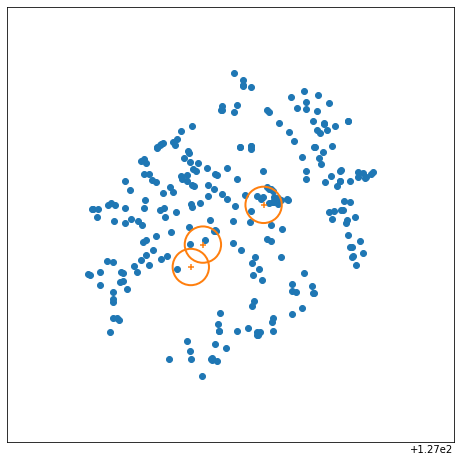

In [23]:
plot_result(points, opts_sites, 0.0027)